In [176]:
import cv2
import re
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA

In [177]:
IMG_HEIGHT = 50
IMG_WIDTH = 50
components = 0.999
tst_size = 0.1

In [178]:
data = os.path.join(os.getcwd(),"Dataset1")
img_lst = os.listdir(data)

# Visualizing images

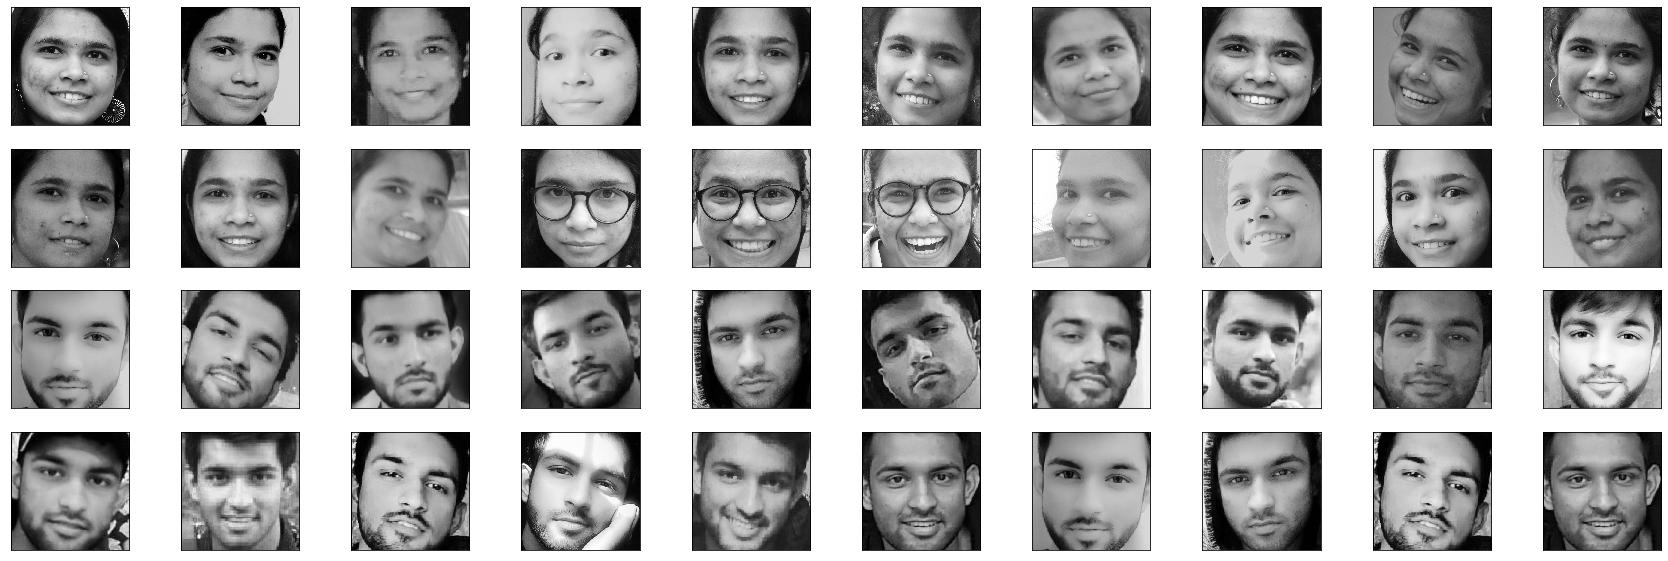

In [141]:
fig = plt.figure(figsize=(30,10))
for img in range(40):
    imgpth = os.path.join(data, img_lst[img])
    im = cv2.imread(imgpth, cv2.IMREAD_COLOR)
    ax = fig.add_subplot(4,10, img + 1, xticks = [],yticks =[])
    ax.imshow(im, cmap = "gray")

# Creating dataset

In [179]:
X = []
y = []
for imgs in (img_lst):
    imagePath = os.path.join(data, imgs)
    im = cv2.imread(imagePath)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im = cv2.resize(im, (IMG_HEIGHT, IMG_WIDTH)) # converting every image into same size
    label=re.split(r'\W+',imgs)[0]
    nam = label[:-2]
    X.append(im)
    y.append(nam)

In [180]:
X = np.array(X) #creating an array of each image
X.shape

(300, 50, 50)

In [181]:
X = X.reshape(X.shape[0],X.shape[1]*X.shape[2]) #converting each image to a single vector
X.shape

(300, 2500)

In [182]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = tst_size, stratify = y, random_state = 5) #stratify allows labels in accordance with the images in test
x_train.shape, x_test.shape    # random state so that everytime same data goes into training & testing

((270, 2500), (30, 2500))

In [183]:
mn = np.mean(x_train, axis = 0)
sd = np.std(x_train, axis = 0)
x_train_norm = ((x_train-mn)/sd) #normalizing the vectors for Principal components
x_test_norm = ((x_test-mn)/sd)

In [184]:
x_train_norm.shape, x_test_norm.shape

((270, 2500), (30, 2500))

In [185]:
pca = PCA(n_components = components, whiten = True) # considers 99.9% components, whiten = ?

In [186]:
pca.fit(x_train_norm) #fitting PCA  model on training set

PCA(copy=True, iterated_power='auto', n_components=0.999, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True)

In [187]:
pca.explained_variance_ratio_.shape 

(224,)

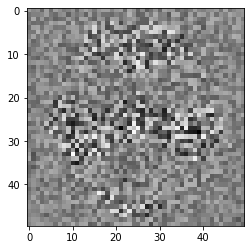

In [188]:
plt.imshow(pca.mean_.reshape((IMG_HEIGHT, IMG_WIDTH)),
           cmap="gray")

In [189]:
x_train = pca.transform(x_train_norm)  # Applying dimensionality reduction on data
x_test = pca.transform(x_test_norm)

In [190]:
x_train.shape, x_test.shape #dimensions reduced from 6400 to 225 after applying PCA

((270, 224), (30, 224))

# Visualizing Eigen faces

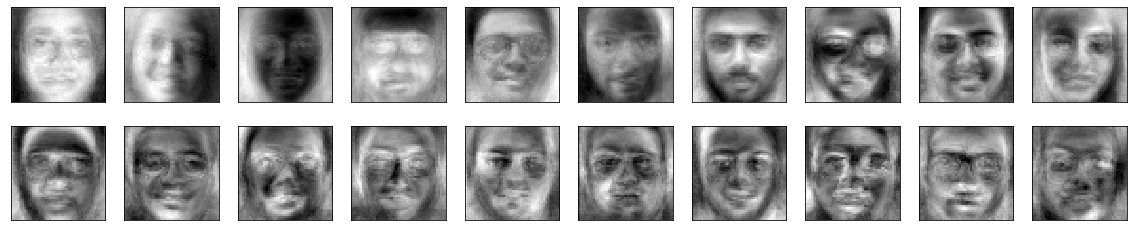

In [191]:
fig = plt.figure(figsize=(20, 4))
for i in range(20):
    ax = fig.add_subplot(2, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape((IMG_HEIGHT, IMG_WIDTH)),
              cmap="gray")

In [192]:
clf = SVC(C = 0.5, kernel = 'linear')   # C = ?

In [193]:
clf.fit(x_train, y_train)   #  Fitting classifier to the training data

SVC(C=0.5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [194]:
clf.predict(x_test) #predicts names of test set

array(['palak', 'jaydeep', 'pankti', 'divyesh', 'parth', 'akshatS',
       'jaydeep', 'divyesh', 'prashant', 'akshatS', 'prashant', 'jigna',
       'parth', 'rushik', 'linson', 'rushik', 'aishwarya', 'hetvi',
       'karan', 'pankti', 'karan', 'aishwarya', 'akshat', 'harshit',
       'hetvi', 'jigna', 'harshit', 'prashant', 'aishwarya', 'pankti'],
      dtype='<U9')

In [195]:
x_test_reconstructed = pca.inverse_transform(x_test) #transform vectors back to original size
x_test_reconstructed.shape

(30, 2500)

Plotting the reconstructed test images

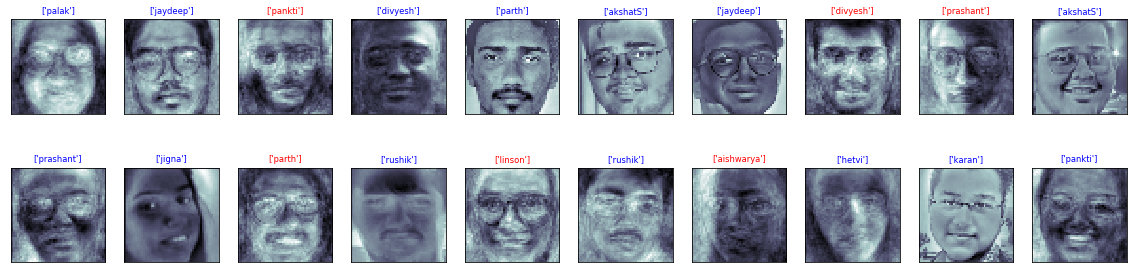

In [196]:
fig = plt.figure(figsize=(20, 5))
for i in range(20):
    ax = fig.add_subplot(2,10, i + 1, xticks=[], yticks=[])
    ax.imshow(x_test_reconstructed[i].reshape((IMG_HEIGHT, IMG_WIDTH)),
              cmap=plt.cm.bone)
    y_pred = clf.predict(x_test[i, np.newaxis])[0] # np.newaxis so that 1D array will become 2D array (x_test is a single vector & cannot be plot)
    color = ('blue' if y_pred == y_test[i] else 'red')
    ax.set_title([y_pred],
                 fontsize='small', color=color)

In [197]:
score = clf.score(x_test, y_test) 
score

0.7

# face detection & recognition on an image

In [198]:
face_csc = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
img = cv2.imread("IMG-20200406-WA0013.jpg", cv2.IMREAD_COLOR)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_csc.detectMultiScale(gray, scaleFactor = 1.03, minNeighbors = 5, minSize = (40,40))
for (x,y, w, h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h), (15,150,100),1)
        roi_gray = img[y:y+h, x:x+w]
        img = cv2.resize(roi_gray, (IMG_HEIGHT, IMG_WIDTH))
        img = img.reshape(-1,1)
        img = pca.transform((img-mn)/sd)
        nam = clf.predict(img)[0]
        cv2.imshow("image",roi_gray)
        print(nam)
        
cv2.waitKey(0)
cv2.destroyAllWindows()     

rushik


# face detection & recognition using webcam

In [162]:
face_csc = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
VC = cv2.VideoCapture(0)
while True:
    ret, img = VC.read()
    #start = time()
    if ret is True:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        continue
    faces = face_csc.detectMultiScale(gray, scaleFactor = 1.2, minNeighbors = 5, minSize = (40,40)) 
    #print(time()-start)

    for (x,y, w, h) in faces:
        labelsize = cv2.getTextSize(nam, cv2.FONT_HERSHEY_DUPLEX, 0.9, 2)
        cv2.rectangle(img,(x,y),(x+w,y+h), (15,150,100),3) #draws rectangle over the detected region
        roi_gray = gray[y:y+h, x:x+w] #converts the detected region into gray
        im = cv2.resize(roi_gray, (IMG_HEIGHT, IMG_WIDTH))
        #print(im.shape)
        im = im.reshape(-1,1)
        #print(im.shape)
        im = pca.transform((im-mn)/sd)
        nam = clf.predict(im)[0] #predicting the detected face
        #print(nam)
        cv2.putText(img, nam, (x,y), cv2.FONT_HERSHEY_DUPLEX, 0.9, (255,255,255), 2) #puts the name tag over the  detected face
    cv2.imshow("image", img)
    ch = cv2.waitKey(1)
    if ch & 0xFF == ord('q'):
        break
VC.release()
cv2.destroyAllWindows()